In [1]:
import pandas as pd
import sqlite3
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q_tables = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(q_tables)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# best selling genres in USA

In [3]:
q1 = """WITH
            track_genre AS
                (
                SELECT
                    t.track_id,
                    t.genre_id,
                    g.name genre_name,
                    il.quantity,
                    i.customer_id
                FROM track t
                INNER JOIN genre g ON g.genre_id = t.genre_id
                INNER JOIN invoice_line il ON il.track_id = t.track_id
                INNER JOIN invoice i ON i.invoice_id = il.invoice_ID
                )
        SELECT tg.genre_name, COUNT(tg.quantity) tracks_total
        FROM track_genre tg
        INNER JOIN customer c ON c.customer_id = tg.customer_id
        WHERE c.country = "USA"
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;"""
run_query(q1)

,genre_name,tracks_total
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Latin,22
7,Pop,22
8,Hip Hop/Rap,20
9,Jazz,14


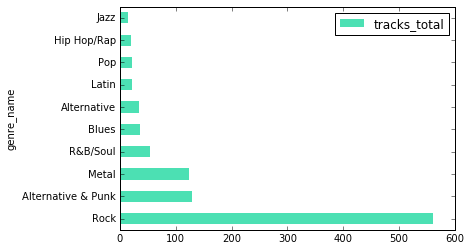

In [4]:
genre_sales_usa = run_query(q1)
genre_sales_usa.set_index("genre_name",drop=True,inplace=True)
genre_sales_usa.plot.barh(edgecolor = "none", color="#4CE0B3")
plt.show()

## notes
rock is the best selling genre by far in the record store chinook. 
task was to find out, which three albums out for should be released in the record store. genres of the albums: HipHop, Punk, Pop, Blues. so due to this visualization, i would choose the Punk, Blues and Pop album to release. 

also this plot shows that chinooks audience seem to be people that like rock, punk and metal very much.

In [5]:
q2 = """WITH
            cust_total_purch AS
                (
                SELECT c.customer_id, c.support_rep_id, SUM(i.total) total_purchased
                FROM customer c
                LEFT JOIN invoice i ON i.customer_id = c.customer_id
                GROUP BY c.customer_id
                ),
            ctp_agents_added AS
                (
                SELECT *
                FROM cust_total_purch ctp
                LEFT JOIN employee e ON e.employee_id = ctp.support_rep_id                
                )
            
        SELECT first_name||" "||last_name name_employee, SUM(total_purchased) sales_revenue
        FROM ctp_agents_added
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;"""
        
run_query(q2)

,name_employee,sales_revenue
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


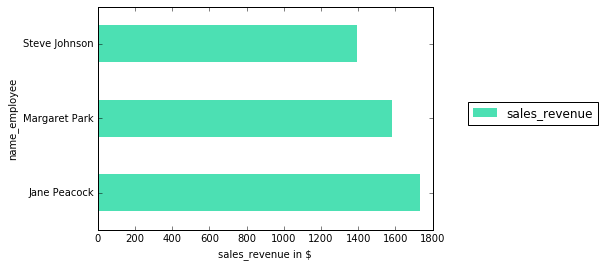

In [6]:
sales_revenue = run_query(q2)
sales_revenue.set_index("name_employee",drop=True,inplace=True)
sales_revenue.plot.barh(edgecolor = "none", color="#4CE0B3")
plt.xlabel("sales_revenue in $")
plt.legend(loc=9, bbox_to_anchor=(1.3, 0.6))
plt.show()

## notes 
jane peacock has best sales_revenues. margaret park was 70 years old, when she was hired(see below). on the frist look it seems women sell better then men. but on one hand we are talking only about three people and on the other Steve Johnson was hired 5 month later then the two women.

In [7]:
q3 = """SELECT *
        FROM employee
        WHERE title = "Sales Support Agent";"""
        
run_query(q3)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
1,4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
2,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [8]:
q4 = """WITH
            cust_total_purch AS
                (
                SELECT
                    CASE
                       WHEN (
                             SELECT count(*)
                             FROM customer
                             where country = c.country
                            ) = 1 THEN "Other"
                       ELSE c.country
                    END AS country,
                    c.customer_id,
                    SUM(i.total) total_purchased,
                    COUNT(i.invoice_id) cust_orders
                FROM customer c
                LEFT JOIN invoice i ON i.customer_id = c.customer_id
                GROUP BY c.customer_id
                ),
            total_table AS
                (
                SELECT
                    country,
                    SUM(total_purchased) total_sales_value,
                    COUNT(customer_id) cust_total,
                    SUM(cust_orders) total_orders
                FROM cust_total_purch
                GROUP BY 1
                ORDER BY 2 DESC
                ),
            final_table AS
                (
                SELECT 
                    *,
                    ROUND(CAST(total_orders as Float) / CAST(cust_total as Float), 2) avg_orders,
                    ROUND(CAST(total_sales_value as Float)/CAST(total_orders as Float), 2) avg_order_value,
                    CASE
                        WHEN country = "Other" THEN 1
                        ELSE 0
                    END AS sort
                FROM total_table
                )
            
        SELECT 
            country,
            total_sales_value,
            cust_total,
            total_orders,
            avg_orders,
            avg_order_value,
            ROUND(avg_orders * avg_order_value, 2) total_cust_order_value
        FROM final_table
        ORDER BY sort ASC;"""
        
run_query(q4)

,country,total_sales_value,cust_total,total_orders,avg_orders,avg_order_value,total_cust_order_value
0,USA,1040.49,13,131,10.08,7.94,80.04
1,Canada,535.59,8,76,9.50,7.05,66.97
2,Brazil,427.68,5,61,12.20,7.01,85.52
3,France,389.07,5,50,10.00,7.78,77.80
4,Germany,334.62,4,41,10.25,8.16,83.64
5,Czech Republic,273.24,2,30,15.00,9.11,136.65
6,United Kingdom,245.52,3,28,9.33,8.77,81.82
7,Portugal,185.13,2,29,14.50,6.38,92.51
8,India,183.15,2,21,10.50,8.72,91.56
9,Other,1094.94,15,147,9.80,7.45,73.01


## visualizations

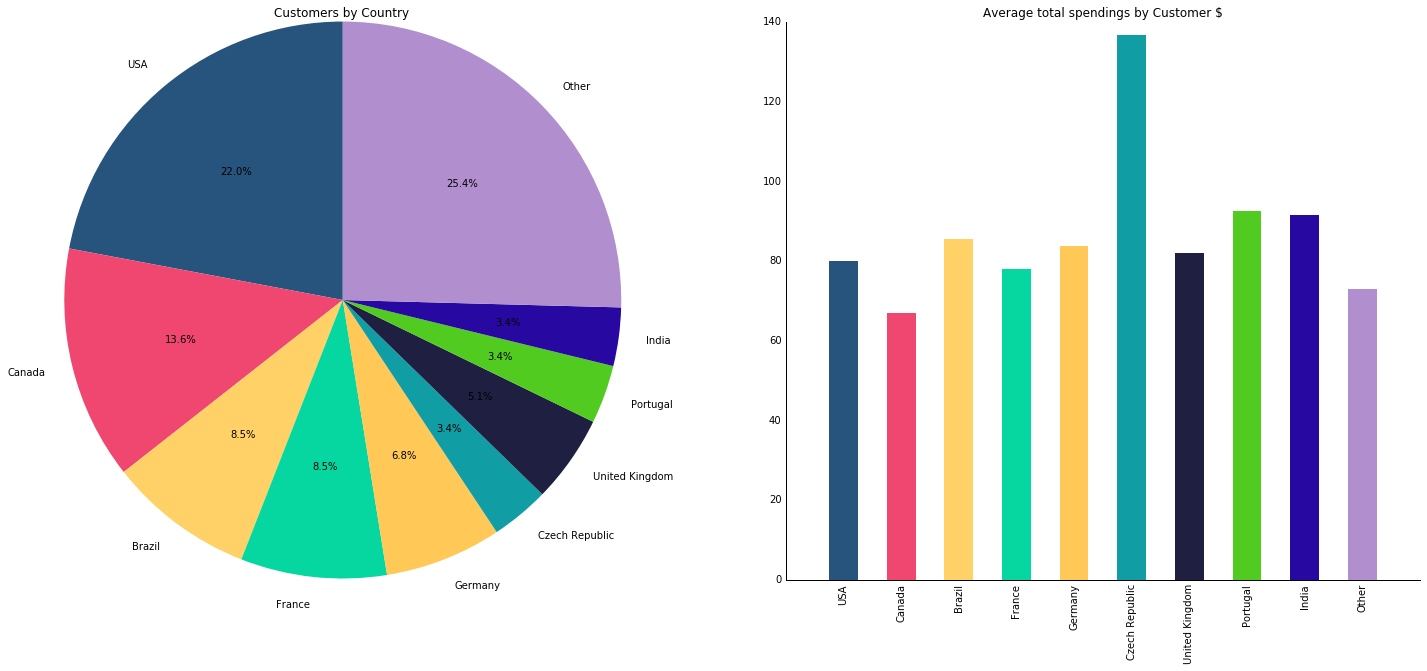

In [9]:
business_data = run_query(q4)
colors = ["#26547C","#EF476F","#FFD166","#06D6A0","#FFC857","#119DA4","#1F2041","#51CB20","#2708A0","#B18FCF"]
fig = plt.figure(figsize=(25, 10))

ax1 = fig.add_subplot(1,2,1)
ax1.pie(business_data["cust_total"], labels=business_data["country"], autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth':0}, colors=colors)
ax1.axis('equal')
ax1.set_title("Customers by Country")

bar_heights = business_data["total_cust_order_value"].values
bar_positions = arange(10) + 0.75
tick_positions = range(1,11)
labels = business_data["country"]

ax2 = fig.add_subplot(1,2,2)
ax2.bar(bar_positions, bar_heights, 0.5, color=colors, edgecolor = "none")
ax2.set_xticks(tick_positions)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xticklabels(labels, rotation=90)
ax2.set_xlim(0,11)
ax2.set_title("Average total spendings by Customer $")

plt.show()

## album purchases vs. individual purchases

In [10]:
q5 = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
"""
run_query(q5)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
